# Note: combined_df_v2.csv is our initial dataset containing high-level planning and low-level reasoning steps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

path = "combined_df_v2.csv"

df = pd.read_csv(path)

df.head()





,custom_id,question,answer,LLR,HLR
0,req_330000,Will's breakfast supplied him 900 calories of ...,Step 1: Calculate the duration of jogging in m...,[('Step 1: Calculate the duration of jogging i...,['Step 1: Calculate the duration of jogging in...
1,req_330001,What is the smallest prime factor of 1821?,Step 1: Identify the properties of the number ...,[('Step 1: Identify the properties of the numb...,['Step 1: Identify the properties of the numbe...
2,req_330002,Billy weighs 9 pounds more than Brad. Brad wei...,Step 1: Determine Brad's weight based on Carl'...,"[(""Step 1: Determine Brad's weight based on Ca...","[""Step 1: Determine Brad's weight based on Car..."
3,req_330003,Simon and Peter have a big stamp collection. S...,Step 1: Calculate the total amount of money Si...,[('Step 1: Calculate the total amount of money...,['Step 1: Calculate the total amount of money ...
4,req_330004,A small zoo houses a variety of 68 wild animal...,Step 1: Determine the initial number of animal...,[('Step 1: Determine the initial number of ani...,['Step 1: Determine the initial number of anim...


In [2]:
df.iloc[0, 3]

'[(\'Step 1: Calculate the duration of jogging in minutes\', \'Since there are 60 minutes in an hour, half an hour is calculated as 60/2, which equals 30 minutes.\'), (\'Step 2: Determine the total calories burned during jogging\', \'Will burns 10 calories per minute, so for 30 minutes, the total calories burned is calculated as 10 * 30, which equals 300 calories.\'), ("Step 3: Calculate Will\'s net calorie intake after jogging", \'To find the net calorie intake, subtract the calories burned from the initial calorie intake: 900 (initial calories) - 300 (calories burned) = 600 calories.\'), (\'Conclusion:\', \'The answer is 600.\')]'

In [3]:
import os
print(os.getcwd())

/Users/nickklatsky/codingProjects/topicsFinal/Hierarchical_Reasoning_with_DLM/official_data_pipeline


In [4]:
df.describe()

# Rename HLR col as HLP
df = df.rename(columns={'HLR': 'HLS'})
df.head()


,custom_id,question,answer,LLR,HLS
0,req_330000,Will's breakfast supplied him 900 calories of ...,Step 1: Calculate the duration of jogging in m...,[('Step 1: Calculate the duration of jogging i...,['Step 1: Calculate the duration of jogging in...
1,req_330001,What is the smallest prime factor of 1821?,Step 1: Identify the properties of the number ...,[('Step 1: Identify the properties of the numb...,['Step 1: Identify the properties of the numbe...
2,req_330002,Billy weighs 9 pounds more than Brad. Brad wei...,Step 1: Determine Brad's weight based on Carl'...,"[(""Step 1: Determine Brad's weight based on Ca...","[""Step 1: Determine Brad's weight based on Car..."
3,req_330003,Simon and Peter have a big stamp collection. S...,Step 1: Calculate the total amount of money Si...,[('Step 1: Calculate the total amount of money...,['Step 1: Calculate the total amount of money ...
4,req_330004,A small zoo houses a variety of 68 wild animal...,Step 1: Determine the initial number of animal...,[('Step 1: Determine the initial number of ani...,['Step 1: Determine the initial number of anim...


In [5]:
df.describe()

,custom_id,question,answer,LLR,HLS
count,395000,395000,395000,395000,395000
unique,395000,13929,370783,370545,258944
top,req_330000,The average age of the 40 members of a compute...,Step 1: Evaluate \( g(\sqrt{2}) \) ; To find \...,"[('Step 1: Evaluate \\( g(\\sqrt{2}) \\)', 'To...",['Step 1: Identify the coordinates of the two ...
freq,1,147,27,27,67


In [6]:
import pandas as pd
import torch
from transformers import GPT2TokenizerFast
import ast

def clean_answer(text):
    text = text.replace('\n\n', ' ')
    text = text.replace('. Step', ' ; Step')
    text = text.rstrip('. ')
    return text

new_rows = []
for index, row in df.iterrows():
    test_q = row['question']
    test_a = row['answer']
    test_llr = row['LLR']
    test_hlr = row['HLS']

    test_q_HL = 'Question: ' + test_q + " ; " + ' High Level Steps: '
    test_a_HL = ' ; '.join(ast.literal_eval(test_hlr)) + ' '

    test_a_LLR = clean_answer(test_a)

    test_full_HL = test_q_HL + " ; " + test_a_HL
    test_full = 'Question: ' + test_q + " ; " + ' Answer: ' +  " ; " + test_a_LLR

    new_rows.append({"high_level": test_full_HL, "low_level": test_full})




/Users/nickklatsky/codingProjects/topicsFinal/Hierarchical_Reasoning_with_DLM/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Output transformed dataset to data/train_data.csv

In [7]:
new_df = pd.DataFrame(new_rows)
new_df.head()

new_df.to_csv('../data/train_data_raw.csv')

# Exploratory Data Analysis

## 1: Load data + tokenizer

In [8]:
import pandas as pd
from transformers import GPT2TokenizerFast
import torch
from tqdm.notebook import tqdm  # Use notebook version for better progress bars
import numpy as np
import os

# Initialize tokenizer
print("Loading tokenizer...")
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
pad_token_str = tokenizer.pad_token
print(f"Using padding token: '{pad_token_str}'")

# Initialize tokenizer
print("Loading tokenizer...")
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# Set padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
pad_token_str = tokenizer.pad_token
print(f"Using padding token: '{pad_token_str}'")

# Define path relative to the notebook location
input_csv_path = '../data/train_data_raw.csv'

print(f"Loading data from {input_csv_path}...")
try:
    # Load the raw training data generated by the previous cells/script
    eda_df = pd.read_csv(input_csv_path)
    # Drop rows with missing values just in case
    eda_df.dropna(subset=['high_level', 'low_level'], inplace=True)
    print(f"Loaded {len(eda_df)} rows.")
    print("Data sample:")
    display(eda_df.head())
except FileNotFoundError:
    print(f"Error: Input file not found at {input_csv_path}")
    print("Please ensure the previous cells or the `training_dataset_builder.py` script has run successfully.")
    eda_df = None
except Exception as e:
    print(f"An error occurred: {e}")
    eda_df = None



Loading tokenizer...
Using padding token: '<|endoftext|>'
Loading tokenizer...
Using padding token: '<|endoftext|>'
Loading data from ../data/train_data_raw.csv...
Loaded 395000 rows.
Data sample:


,Unnamed: 0,high_level,low_level
0,0,Question: Will's breakfast supplied him 900 ca...,Question: Will's breakfast supplied him 900 ca...
1,1,Question: What is the smallest prime factor of...,Question: What is the smallest prime factor of...
2,2,Question: Billy weighs 9 pounds more than Brad...,Question: Billy weighs 9 pounds more than Brad...
3,3,Question: Simon and Peter have a big stamp col...,Question: Simon and Peter have a big stamp col...
4,4,Question: A small zoo houses a variety of 68 w...,Question: A small zoo houses a variety of 68 w...


## 2: Test tokenizer

In [9]:
print("Tokenizing a sample (first 5 rows)...")
sample_df = eda_df.head().copy() # Work on a copy

# Ensure data is string type
sample_df['high_level'] = sample_df['high_level'].astype(str)
sample_df['low_level'] = sample_df['low_level'].astype(str)

# Tokenize
sample_df['hl_tokens'] = sample_df['high_level'].apply(lambda x: tokenizer.encode(x))
sample_df['ll_tokens'] = sample_df['low_level'].apply(lambda x: tokenizer.encode(x))

# Get lengths
sample_df['hl_len'] = sample_df['hl_tokens'].apply(len)
sample_df['ll_len'] = sample_df['ll_tokens'].apply(len)

print("\nSample Data with Token Lengths:")
display(sample_df[['high_level', 'hl_len', 'low_level', 'll_len']])

print("\nExample Tokenized Output (Row 0):")
print("High Level Tokens:", sample_df.loc[0, 'hl_tokens'])
print("Decoded:", tokenizer.decode(sample_df.loc[0, 'hl_tokens'])) # Optional: decode back
print("\nLow Level Tokens:", sample_df.loc[0, 'll_tokens'])
print("Decoded:", tokenizer.decode(sample_df.loc[0, 'll_tokens'])) # Optional: decode back

print("\n")

print("\nExample Tokenized Output (Row 1):")
print("High Level Tokens:", sample_df.loc[1, 'hl_tokens'])
print("Decoded:", tokenizer.decode(sample_df.loc[1, 'hl_tokens'])) # Optional: decode back
print("\nLow Level Tokens:", sample_df.loc[1, 'll_tokens'])
print("Decoded:", tokenizer.decode(sample_df.loc[1, 'll_tokens'])) # Optional: decode back



Tokenizing a sample (first 5 rows)...

Sample Data with Token Lengths:


,high_level,hl_len,low_level,ll_len
0,Question: Will's breakfast supplied him 900 ca...,94,Question: Will's breakfast supplied him 900 ca...,180
1,Question: What is the smallest prime factor of...,95,Question: What is the smallest prime factor of...,222
2,Question: Billy weighs 9 pounds more than Brad...,72,Question: Billy weighs 9 pounds more than Brad...,122
3,Question: Simon and Peter have a big stamp col...,135,Question: Simon and Peter have a big stamp col...,240
4,Question: A small zoo houses a variety of 68 w...,212,Question: A small zoo houses a variety of 68 w...,422



Example Tokenized Output (Row 0):
High Level Tokens: [24361, 25, 2561, 338, 12607, 14275, 683, 15897, 14653, 286, 2568, 13, 3244, 339, 3066, 284, 48342, 329, 2063, 281, 1711, 11, 543, 973, 510, 838, 14653, 286, 2568, 583, 5664, 13, 1867, 318, 2561, 338, 2010, 28740, 10337, 706, 474, 30853, 30, 2162, 220, 3334, 5684, 32144, 25, 220, 2162, 5012, 352, 25, 27131, 378, 262, 9478, 286, 474, 30853, 287, 2431, 2162, 5012, 362, 25, 45559, 3810, 262, 2472, 14653, 11544, 1141, 474, 30853, 2162, 5012, 513, 25, 27131, 378, 2561, 338, 2010, 28740, 10337, 706, 474, 30853, 2162, 44790, 25, 220]
Decoded: Question: Will's breakfast supplied him 900 calories of energy. Then he decided to jog for half an hour, which used up 10 calories of energy per minute. What is Will's net calorie intake after jogging? ;  High Level Steps:  ; Step 1: Calculate the duration of jogging in minutes ; Step 2: Determine the total calories burned during jogging ; Step 3: Calculate Will's net calorie intake after jogging ; Co

## 3: Split into fragments, get token lengths

### Define fragment extraction function

In [10]:
import pandas as pd
from transformers import GPT2TokenizerFast
import torch
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns



def extract_tokenize_fragments(row_index, high_level_text, low_level_text, tokenizer, delimiter=" ; "):
    """
    Extracts HL and LL fragments from texts, tokenizes them,
    and returns a list of dictionaries for this row.
    Splits "Conclusion:" prefix into its own fragment.
    """
    fragments_data = []
    # Use separate counters for accurate in-row indexing after potential splits
    hl_fragment_output_index = 0
    ll_fragment_output_index = 0
    conclusion_prefix = "Conclusion:" # Define the prefix to split

    # --- Process High Level ---
    if isinstance(high_level_text, str):
        hl_fragments_raw = [frag.strip() for frag in high_level_text.split(delimiter)]
        # Using slice [2:] to discard "Question:" and "High Level Steps:" prefix.
        # Change to [1:] if you want to include "High Level Steps:" as the first fragment.
        hl_step_fragments = [frag for frag in hl_fragments_raw[2:] if frag]

        for frag_text in hl_step_fragments:
            try:
                conclusion_idx = frag_text.find(conclusion_prefix)

                # Case 1: "Conclusion:" is found mid-fragment
                if conclusion_idx > 0:
                    part1 = frag_text[:conclusion_idx].strip()
                    # Add part 1 if it's not empty
                    if part1:
                        len1 = len(tokenizer.encode(part1))
                        fragments_data.append({
                            'original_index': row_index,
                            'fragment_index_in_row': hl_fragment_output_index,
                            'fragment_type': 'HL',
                            'fragment_text': part1,
                            'token_length': len1
                        })
                        hl_fragment_output_index += 1

                    # Add "Conclusion:" prefix
                    len_prefix = len(tokenizer.encode(conclusion_prefix))
                    fragments_data.append({
                        'original_index': row_index,
                        'fragment_index_in_row': hl_fragment_output_index,
                        'fragment_type': 'HL',
                        'fragment_text': conclusion_prefix,
                        'token_length': len_prefix
                    })
                    hl_fragment_output_index += 1

                    # Add remaining text after prefix, if any
                    remaining_text = frag_text[conclusion_idx + len(conclusion_prefix):].strip()
                    if remaining_text:
                        len_remaining = len(tokenizer.encode(remaining_text))
                        fragments_data.append({
                             'original_index': row_index,
                             'fragment_index_in_row': hl_fragment_output_index,
                             'fragment_type': 'HL',
                             'fragment_text': remaining_text,
                             'token_length': len_remaining
                        })
                        hl_fragment_output_index += 1

                # Case 2: Fragment *starts* with "Conclusion:"
                elif conclusion_idx == 0:
                    # Add "Conclusion:" prefix
                    len_prefix = len(tokenizer.encode(conclusion_prefix))
                    fragments_data.append({
                        'original_index': row_index,
                        'fragment_index_in_row': hl_fragment_output_index,
                        'fragment_type': 'HL',
                        'fragment_text': conclusion_prefix,
                        'token_length': len_prefix
                    })
                    hl_fragment_output_index += 1

                    # Add remaining text after prefix, if any
                    remaining_text = frag_text[len(conclusion_prefix):].strip()
                    if remaining_text:
                        len_remaining = len(tokenizer.encode(remaining_text))
                        fragments_data.append({
                             'original_index': row_index,
                             'fragment_index_in_row': hl_fragment_output_index,
                             'fragment_type': 'HL',
                             'fragment_text': remaining_text,
                             'token_length': len_remaining
                        })
                        hl_fragment_output_index += 1

                # Case 3: No "Conclusion:", add as a single fragment
                else:
                    token_length = len(tokenizer.encode(frag_text))
                    fragments_data.append({
                        'original_index': row_index,
                        'fragment_index_in_row': hl_fragment_output_index,
                        'fragment_type': 'HL',
                        'fragment_text': frag_text,
                        'token_length': token_length
                    })
                    hl_fragment_output_index += 1

            except Exception as e:
                 print(f"Error tokenizing/processing HL fragment at index {row_index}: {e} - Text: {frag_text[:50]}...")


    # --- Process Low Level ---
    if isinstance(low_level_text, str):
        ll_fragments_raw = [frag.strip() for frag in low_level_text.split(delimiter)]
        # Using slice [2:] to discard "Question:" and "Answer:" prefix.
        # Change to [1:] if you want to include "Answer:" as the first fragment.
        ll_reasoning_fragments = [frag for frag in ll_fragments_raw[2:] if frag]

        for frag_text in ll_reasoning_fragments:
            try:
                 conclusion_idx = frag_text.find(conclusion_prefix)

                 # Case 1: "Conclusion:" is found mid-fragment
                 if conclusion_idx > 0:
                     part1 = frag_text[:conclusion_idx].strip()
                     # Add part 1 if it's not empty
                     if part1:
                         len1 = len(tokenizer.encode(part1))
                         fragments_data.append({
                             'original_index': row_index,
                             'fragment_index_in_row': ll_fragment_output_index,
                             'fragment_type': 'LL',
                             'fragment_text': part1,
                             'token_length': len1
                         })
                         ll_fragment_output_index += 1

                     # Add "Conclusion:" prefix
                     len_prefix = len(tokenizer.encode(conclusion_prefix))
                     fragments_data.append({
                         'original_index': row_index,
                         'fragment_index_in_row': ll_fragment_output_index,
                         'fragment_type': 'LL',
                         'fragment_text': conclusion_prefix,
                         'token_length': len_prefix
                     })
                     ll_fragment_output_index += 1

                     # Add remaining text after prefix, if any
                     remaining_text = frag_text[conclusion_idx + len(conclusion_prefix):].strip()
                     if remaining_text:
                         len_remaining = len(tokenizer.encode(remaining_text))
                         fragments_data.append({
                              'original_index': row_index,
                              'fragment_index_in_row': ll_fragment_output_index,
                              'fragment_type': 'LL',
                              'fragment_text': remaining_text,
                              'token_length': len_remaining
                         })
                         ll_fragment_output_index += 1

                 # Case 2: Fragment *starts* with "Conclusion:"
                 elif conclusion_idx == 0:
                    # Add "Conclusion:" prefix
                    len_prefix = len(tokenizer.encode(conclusion_prefix))
                    fragments_data.append({
                        'original_index': row_index,
                        'fragment_index_in_row': ll_fragment_output_index,
                        'fragment_type': 'LL',
                        'fragment_text': conclusion_prefix,
                        'token_length': len_prefix
                    })
                    ll_fragment_output_index += 1

                    # Add remaining text after prefix, if any
                    remaining_text = frag_text[len(conclusion_prefix):].strip()
                    if remaining_text:
                        len_remaining = len(tokenizer.encode(remaining_text))
                        fragments_data.append({
                             'original_index': row_index,
                             'fragment_index_in_row': ll_fragment_output_index,
                             'fragment_type': 'LL',
                             'fragment_text': remaining_text,
                             'token_length': len_remaining
                        })
                        ll_fragment_output_index += 1

                 # Case 3: No "Conclusion:", add as a single fragment
                 else:
                     token_length = len(tokenizer.encode(frag_text))
                     fragments_data.append({
                         'original_index': row_index,
                         'fragment_index_in_row': ll_fragment_output_index,
                         'fragment_type': 'LL',
                         'fragment_text': frag_text,
                         'token_length': token_length
                     })
                     ll_fragment_output_index += 1
            except Exception as e:
                 print(f"Error tokenizing/processing LL fragment at index {row_index}: {e} - Text: {frag_text[:50]}...")


    return fragments_data

### Implement extraction


--- Verifying fragment extraction for row index: 5 ---

Original High Level Text:
```
Question: There are 66 goats at a farm and twice as many chickens. If the number of ducks is half of the total of the goats and chickens, and the number of pigs is a third of the number of ducks, how many more goats are there than pigs? ;  High Level Steps:  ; Step 1: Determine the number of chickens based on the number of goats ; Step 2: Calculate the total number of goats and chickens to find the number of ducks ; Step 3: Determine the number of pigs based on the number of ducks ; Step 4: Find the difference between the number of goats and pigs ; Conclusion: 
```
--------------------
Original Low Level Text:
```
Question: There are 66 goats at a farm and twice as many chickens. If the number of ducks is half of the total of the goats and chickens, and the number of pigs is a third of the number of ducks, how many more goats are there than pigs? ;  Answer:  ; Step 1: Determine the number of chickens

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Processing Rows: 100%|██████████| 395000/395000 [07:09<00:00, 919.13it/s] 



Created DataFrame with 5605710 total fragments.

--- Verifying fragments_df content for example row ---
Fragments stored in DataFrame for original_index 5:


,original_index,fragment_type,fragment_index_in_row,token_length,fragment_text
66,5,HL,0,15,Step 1: Determine the number of chickens based...
67,5,HL,1,18,Step 2: Calculate the total number of goats an...
68,5,HL,2,15,Step 3: Determine the number of pigs based on ...
69,5,HL,3,13,Step 4: Find the difference between the number...
70,5,HL,4,2,Conclusion:
71,5,LL,0,15,Step 1: Determine the number of chickens based...
72,5,LL,1,30,"Since there are 66 goats at the farm, and the ..."
73,5,LL,2,18,Step 2: Calculate the total number of goats an...
74,5,LL,3,37,The total number of goats and chickens is 66 +...
75,5,LL,4,15,Step 3: Determine the number of pigs based on ...


--------------------

--- Calculating Max Lengths and Statistics ---
Max HL Fragment Token Length: 383
Max LL Fragment Token Length: 921

Visualizing fragment length distributions...


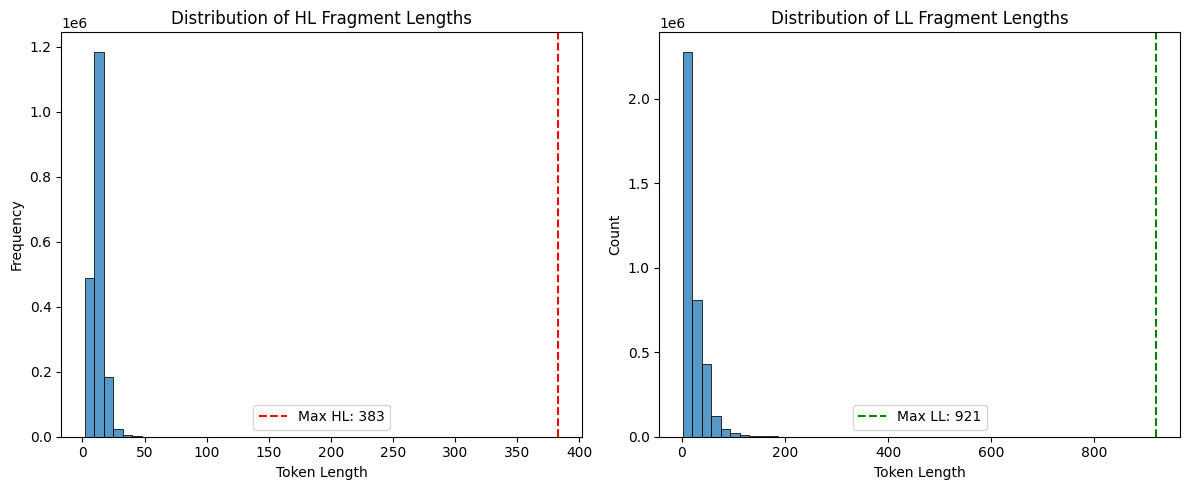


Fragment Length Stats by Type:
                   count       mean        std  min   25%   50%   75%    max
fragment_type                                                               
HL             1887206.0  11.550913   6.180287  2.0   9.0  12.0  15.0  383.0
LL             3718504.0  22.351867  20.608189  2.0  10.0  15.0  32.0  921.0

--- Note on Reconstructing Sequences ---
The 'fragments_df' DataFrame now contains all necessary information:
  - 'original_index': Links fragment back to its source row in 'eda_df'.
  - 'fragment_type': Identifies fragment as 'HL' (High Level) or 'LL' (Low Level).
  - 'fragment_index_in_row': Indicates the order of the fragment within its type for that row.
  - 'fragment_text': The actual text content of the fragment.
  - 'token_length': The pre-calculated number of GPT2 tokens.

This structure allows you to:
  1. Group by 'original_index'.
  2. Within each group, sort fragments by 'fragment_type' and 'fragment_index_in_row' (or any custom order).
  

In [11]:
import pandas as pd
from transformers import GPT2TokenizerFast
import torch
# Use standard tqdm as notebook version caused issues
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns # Ensure installed: pip install seaborn

# --- Assume tokenizer and eda_df (full or subset) are loaded ---

# --- Function Definition (assuming it's defined correctly above) ---
# def extract_tokenize_fragments(row_index, high_level_text, low_level_text, tokenizer, delimiter=" ; "): ...
# --- Verification Step: Process a single example row ---
example_row_index = 5 # Choose an index to inspect (e.g., 5)
example_fragments_df = None # Initialize DataFrame for the example

if eda_df is not None and example_row_index < len(eda_df):
    print(f"\n--- Verifying fragment extraction for row index: {example_row_index} ---")
    example_row = eda_df.iloc[example_row_index]
    example_hl_text = example_row.get('high_level', 'N/A')
    example_ll_text = example_row.get('low_level', 'N/A')

    # --- Log: Print Original Texts ---
    print("\nOriginal High Level Text:")
    print("```")
    print(example_hl_text)
    print("```")
    print("-" * 20)
    print("Original Low Level Text:")
    print("```")
    print(example_ll_text)
    print("```")
    print("-" * 20)

    # Call the function just for this row
    example_fragments_list = extract_tokenize_fragments(
        example_row_index,
        example_hl_text,
        example_ll_text,
        tokenizer
    )

    print(f"\nExtracted Fragments & Details (Row {example_row_index}):")
    if not example_fragments_list:
        print("  No fragments extracted for this example row.")
    else:
        # --- Create DataFrame for the example row's fragments ---
        example_fragments_df = pd.DataFrame(example_fragments_list)
        print(f"  Stored fragments for row {example_row_index} in `example_fragments_df`.")
        # Log details from the list (easier to read here than full df display)
        for frag_data in example_fragments_list:
             print(f"  - Type: {frag_data['fragment_type']:<3} | "
                   f"IndexInRow: {frag_data['fragment_index_in_row']:<2} | "
                   f"Tokens: {frag_data['token_length']:<4} | "
                   f"Text: '{frag_data['fragment_text'][:80]}...'") # Truncate text for log clarity
    print("-" * 20)
    print("You can now display `example_fragments_df` manually in the next cell.")

else:
    print(f"Cannot verify example row index {example_row_index}. DataFrame might be empty or index out of bounds.")

# --- Main Processing (The rest of the cell remains the same) ---
# print(f"\n--- Processing all {len(eda_df)} rows in the current DataFrame ---")
# ... (rest of the code for processing all rows, creating fragments_df, analysis) ...

# --- Main Processing: Get all fragments (using the current eda_df, which might be a subset) ---
print(f"\n--- Processing all {len(eda_df)} rows in the current DataFrame ---")
all_fragments_list = []
if eda_df is not None:
    # Use tqdm for progress indication
    for index, row in tqdm(eda_df.iterrows(), total=len(eda_df), desc="Processing Rows"):
        # Add a check for logging the example row *during* the main loop if desired (optional)
        # if index == example_row_index:
        #    print(f"\nProcessing example row {index} within the main loop...")
        row_fragments = extract_tokenize_fragments(
            index,
            row.get('high_level'), # Use .get for safety
            row.get('low_level'),
            tokenizer
        )
        all_fragments_list.extend(row_fragments)

    if not all_fragments_list:
        print("Error: No fragments were extracted during main processing.")
        fragments_df = None
        max_len_hl_frag = None
        max_len_ll_frag = None
    else:
        # Create the DataFrame where each row is a single fragment
        fragments_df = pd.DataFrame(all_fragments_list)
        print(f"\nCreated DataFrame with {len(fragments_df)} total fragments.")
        print("\n--- Verifying fragments_df content for example row ---")
        example_fragments_in_df = fragments_df[fragments_df['original_index'] == example_row_index]
        if example_fragments_in_df.empty:
             print(f"No fragments found in fragments_df for original_index {example_row_index}")
        else:
             print(f"Fragments stored in DataFrame for original_index {example_row_index}:")
             # Display relevant columns for verification
             display(example_fragments_in_df[['original_index', 'fragment_type', 'fragment_index_in_row', 'token_length', 'fragment_text']])
        print("-" * 20)


        # --- The rest of the analysis (Max Lengths, Visualization, Stats) ---
        print("\n--- Calculating Max Lengths and Statistics ---")
        # --- Find Max Lengths by Fragment Type ---
        max_lengths = fragments_df.groupby('fragment_type')['token_length'].max()
        max_len_hl_frag = max_lengths.get('HL', None)
        max_len_ll_frag = max_lengths.get('LL', None)

        if max_len_hl_frag is not None: print(f"Max HL Fragment Token Length: {max_len_hl_frag}")
        else: print("No HL fragments found.")
        if max_len_ll_frag is not None: print(f"Max LL Fragment Token Length: {max_len_ll_frag}")
        else: print("No LL fragments found.")

        # --- Visualize Distribution by Type ---
        if max_len_hl_frag is not None or max_len_ll_frag is not None:
            # (Visualization code remains the same as before)
            print("\nVisualizing fragment length distributions...")
            plt.figure(figsize=(12, 5))
            if max_len_hl_frag is not None:
                 plt.subplot(1, 2, 1)
                 sns.histplot(fragments_df[fragments_df['fragment_type'] == 'HL']['token_length'], bins=50)
                 plt.title('Distribution of HL Fragment Lengths')
                 plt.xlabel('Token Length'); plt.ylabel('Frequency')
                 plt.axvline(max_len_hl_frag, color='r', linestyle='--', label=f'Max HL: {max_len_hl_frag}'); plt.legend()
            if max_len_ll_frag is not None:
                 plt.subplot(1, 2, 2)
                 sns.histplot(fragments_df[fragments_df['fragment_type'] == 'LL']['token_length'], bins=50)
                 plt.title('Distribution of LL Fragment Lengths')
                 plt.xlabel('Token Length')
                 plt.axvline(max_len_ll_frag, color='g', linestyle='--', label=f'Max LL: {max_len_ll_frag}'); plt.legend()
            if max_len_hl_frag is None or max_len_ll_frag is None:
                 plt.subplot(1, 2, 1 if max_len_ll_frag is None else 2).set_ylabel('')
                 plt.gcf().set_size_inches(6, 5)
            plt.tight_layout(); plt.show()

            # Display stats by type
            print("\nFragment Length Stats by Type:")
            print(fragments_df.groupby('fragment_type')['token_length'].describe())
        else:
            print("\nSkipping visualization as no fragments were found.")
else:
    print("Skipping main processing as eda_df is None.")
    fragments_df = None
    max_len_hl_frag = None
    max_len_ll_frag = None


# --- Explanation for Reconstruction/Prepending ---
print("\n--- Note on Reconstructing Sequences ---")
if fragments_df is not None:
    print("The 'fragments_df' DataFrame now contains all necessary information:")
    print("  - 'original_index': Links fragment back to its source row in 'eda_df'.")
    print("  - 'fragment_type': Identifies fragment as 'HL' (High Level) or 'LL' (Low Level).")
    print("  - 'fragment_index_in_row': Indicates the order of the fragment within its type for that row.")
    print("  - 'fragment_text': The actual text content of the fragment.")
    print("  - 'token_length': The pre-calculated number of GPT2 tokens.")
    print("\nThis structure allows you to:")
    print("  1. Group by 'original_index'.")
    print("  2. Within each group, sort fragments by 'fragment_type' and 'fragment_index_in_row' (or any custom order).")
    print("  3. Prepend '[{token_length}]' to 'fragment_text'.")
    print("  4. Join the modified fragments to reconstruct sequences.")
else:
    print("Cannot provide reconstruction notes as 'fragments_df' was not created.")


# Update the variables used by subsequent cells
max_len_hl = max_len_hl_frag
max_len_ll = max_len_ll_frag

In [12]:
fragments_df[fragments_df['original_index'] == 1]

,original_index,fragment_index_in_row,fragment_type,fragment_text,token_length
12,1,0,HL,Step 1: Identify the properties of the number ...,18
13,1,1,HL,Step 2: Check for divisibility by the next sma...,17
14,1,2,HL,Step 3: Perform the division of 1821 by 3 to f...,16
15,1,3,HL,Step 4: Determine if 607 is a prime number or ...,17
16,1,4,HL,Conclusion:,2
17,1,0,LL,Step 1: Identify the properties of the number ...,18
18,1,1,LL,"Since 1821 is an odd number, it cannot be divi...",22
19,1,2,LL,Step 2: Check for divisibility by the next sma...,17
20,1,3,LL,"To determine if 1821 is divisible by 3, we sum...",56
21,1,4,LL,Step 3: Perform the division of 1821 by 3 to f...,16


# Create uniform length & length pre-pended datasets

In [13]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns # Ensure installed

# --- Configuration ---
# Assume eda_df, fragments_df, tokenizer, pad_token_str are available from previous cells
# Ensure the 'token_length' column in fragments_df is integer type
if 'fragments_df' in locals() and fragments_df is not None:
     fragments_df['token_length'] = fragments_df['token_length'].astype(int)
else:
     print("Error: fragments_df not found. Please run previous cells.")
     # Optional: exit or skip
     fragments_df = None # Set to None to skip downstream steps cleanly

if 'pad_token_str' not in globals() and 'pad_token_str' not in locals():
     # Attempt to define it if tokenizer exists
     if 'tokenizer' in locals() and tokenizer is not None:
         if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
         pad_token_str = tokenizer.pad_token
         print("Warning: 'pad_token_str' was not found, defined it from tokenizer.")
     else:
        raise NameError("Execution Error: 'pad_token_str' and 'tokenizer' are not defined. Please run previous cells.")

HL_TARGET_LEN = 35
LL_TARGET_LEN = 100
OUTPUT_DELIMITER = " ; "
HL_PLAN_PREFIX = "High-Level Plan"
LL_REASONING_PREFIX = "Low-Level Reasoning"
OUTPUT_DIR = "../data" # Make sure this directory exists
PREPEND_FILENAME = "train_len_prepend.csv"
UNIFORM_FILENAME = "train_len_uniform.csv"

# Make sure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Helper Function to Extract Question ---
def extract_question(text):
    """Extracts question text after 'Question: ' and before the first ';'. """
    if not isinstance(text, str): return ""
    try:
        q_start = text.find("Question: ") + len("Question: ")
        q_end = text.find(OUTPUT_DELIMITER, q_start)
        if q_start < len("Question: ") or q_end == -1:
             # print(f"Warning: Could not parse question format: {text[:100]}...")
             return text # Return original text if parsing fails? Or empty string?
        return text[q_start:q_end].strip()
    except Exception as e:
        # print(f"Error extracting question: {e} from {text[:100]}...")
        return ""

# --- 1. Extract Original Questions ---
if 'eda_df' not in locals() or eda_df is None:
     print("Error: `eda_df` is not available. Cannot extract questions.")
     question_map = {} # Define as empty to prevent downstream errors
else:
     print("Extracting original questions...")
     question_map = eda_df['high_level'].apply(extract_question).to_dict()
     print(f"Sample question (index 5): {question_map.get(5, 'Not Found')}")


# --- Check if fragments_df exists before proceeding ---
if fragments_df is not None:

     # --- 2a. Prepare for train_len_prepend ---
     print("Preparing fragments for train_len_prepend...")
     fragments_df['prepended_text'] = fragments_df.apply(
         lambda row: f"[{row['token_length']}] {row['fragment_text']}", axis=1
     )

     # --- 2b. Prepare for train_len_uniform ---
     print("Preparing fragments for train_len_uniform...")
     # Modified function to accept pad_token
     def pad_fragment(row, pad_token):
         target_len = HL_TARGET_LEN if row['fragment_type'] == 'HL' else LL_TARGET_LEN
         current_len = row['token_length']
         pad_needed = max(0, target_len - current_len)
         # Removed the check for pad_token_str here
         return row['fragment_text'] + (pad_token * pad_needed) # Use the argument

     # Modified apply call to pass pad_token_str
     fragments_df['padded_text'] = fragments_df.apply(
         pad_fragment,
         axis=1,
         args=(pad_token_str,) # Pass pad_token_str via args
     )

     # Verify padding for a sample fragment (optional)
     if not fragments_df.empty:
          sample_padded_frag = fragments_df.iloc[0]
          print(f"Sample padding check (Fragment 0): Type={sample_padded_frag['fragment_type']}, Orig Len={sample_padded_frag['token_length']}")
          # Optional detailed verification can be added here if needed
     else:
          print("Skipping padding check as fragments_df is empty.")


     # --- 3. Group and Reconstruct Sequences ---
     tqdm.pandas(desc="Building Prepended Sequences")

          # Function to build one sequence row (UPDATED)
     def build_sequence(group, text_col_name):
          original_index = group.name
          question_text = question_map.get(original_index, "[QUESTION NOT FOUND]") # Get question

          # Get HL fragments (no change needed here)
          hl_frags = group[group['fragment_type'] == 'HL'].sort_values('fragment_index_in_row')[text_col_name]

          # Get LL fragments BUT filter out the step/conclusion headers
          ll_group = group[group['fragment_type'] == 'LL'].sort_values('fragment_index_in_row')

          # Filter out rows where fragment_text starts with "Step " or is exactly "Conclusion:"
          # Adjust the startswith('Step ') condition if step numbers can have multiple digits
          # and are followed by ':'. A regex might be more robust if format varies.
          reasoning_frags_only = ll_group[
               ~ll_group['fragment_text'].str.startswith('Step ', na=False) & \
               ~ll_group['fragment_text'].str.startswith('Conclusion:', na=False) # Check against the exact prefix we added
          ][text_col_name]

          # Join fragments
          joined_hl = OUTPUT_DELIMITER.join(hl_frags)
          joined_ll_reasoning = OUTPUT_DELIMITER.join(reasoning_frags_only) # Join only the filtered reasoning

          # Construct final string
          # Format: Question + HL_PREFIX + HL_FRAGS + LL_PREFIX + LL_REASONING_FRAGS_ONLY
          parts = [
               f"Question: {question_text}", # Add "Question: " prefix back
               HL_PLAN_PREFIX,
               joined_hl,
               LL_REASONING_PREFIX,
               joined_ll_reasoning # Use the filtered LL fragments
          ]
          # Filter out empty parts that might result if a type had no fragments
          parts = [part for part in parts if part] # Especially important if all LL frags were headers
          return OUTPUT_DELIMITER.join(parts) 

     grouped_fragments = fragments_df.groupby('original_index')

     print("Building prepended sequences...")
     prepended_sequences = grouped_fragments.progress_apply(build_sequence, text_col_name='prepended_text')
     prepended_df = pd.DataFrame({'full_sequence': prepended_sequences})
     prepended_df.index.name = 'original_index'
     print("Prepended sequences sample:")
     display(prepended_df.head())

     tqdm.pandas(desc="Building Uniform Sequences")
     print("\nBuilding uniform length sequences...")
     uniform_sequences = grouped_fragments.progress_apply(build_sequence, text_col_name='padded_text')
     uniform_df = pd.DataFrame({'full_sequence': uniform_sequences})
     uniform_df.index.name = 'original_index'
     print("Uniform length sequences sample:")
     display(uniform_df.head())

     # --- 4. Save Results ---
     prepend_path = os.path.join(OUTPUT_DIR, PREPEND_FILENAME)
     uniform_path = os.path.join(OUTPUT_DIR, UNIFORM_FILENAME)

     print(f"\nSaving prepended data to: {prepend_path}")
     prepended_df.to_csv(prepend_path)

     print(f"Saving uniform length data to: {uniform_path}")
     uniform_df.to_csv(uniform_path)

     print("\nProcessing finished.")

else: # This else corresponds to "if fragments_df is not None:"
     print("Skipping sequence building and saving as 'fragments_df' is not available.")


Extracting original questions...
Sample question (index 5): There are 66 goats at a farm and twice as many chickens. If the number of ducks is half of the total of the goats and chickens, and the number of pigs is a third of the number of ducks, how many more goats are there than pigs?
Preparing fragments for train_len_prepend...
Preparing fragments for train_len_uniform...
Sample padding check (Fragment 0): Type=HL, Orig Len=12
Building prepended sequences...


Building Prepended Sequences: 100%|██████████| 395000/395000 [07:14<00:00, 909.46it/s] 

Prepended sequences sample:


,full_sequence
original_index,
0,Question: Will's breakfast supplied him 900 ca...
1,Question: What is the smallest prime factor of...
2,Question: Billy weighs 9 pounds more than Brad...
3,Question: Simon and Peter have a big stamp col...
4,Question: A small zoo houses a variety of 68 w...



Building uniform length sequences...


Building Uniform Sequences: 100%|██████████| 395000/395000 [08:14<00:00, 798.90it/s] 

Uniform length sequences sample:


,full_sequence
original_index,
0,Question: Will's breakfast supplied him 900 ca...
1,Question: What is the smallest prime factor of...
2,Question: Billy weighs 9 pounds more than Brad...
3,Question: Simon and Peter have a big stamp col...
4,Question: A small zoo houses a variety of 68 w...



Saving prepended data to: ../data/train_len_prepend.csv
Saving uniform length data to: ../data/train_len_uniform.csv

Processing finished.
